# Functions Used
>This page holds most of the functions that were uesd to read in the data, determine the distance of each lifeline from the epicenter of the disaster, group the lifelines and then return the life lines within the disaster area. Towards the bottom there is some code from us playing around with maps and heat maps. The parts of this page that were used have been formally written in python files and stored in the "Functions" folder.

In [3]:
import pandas as pd
import numpy as np
from ipyleaflet import Map,Marker,CircleMarker,Heatmap
from ipywidgets import HTML
from ipyleaflet import Popup

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
data = pd.read_csv("../datasets/full_dataset.csv")

> When trying to find the distance between two points using lat and long, we could not just use euclidean distance due to the curve of the earth and the way lat,long fall on the earth. Below is the equation to do so with credit given to the writer.

In [7]:
# Distance between to latitude and longitude points
# Haversine formula example in Python
# Author: Wayne Dyck

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 3959 # miles
    #radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

> This function was altered in the final stages, but in general it takes in the epicenter of the storm, radius of the storm and the dataframe with all of the lifelines pulled by the api for a specific area. It outputs a dataframe that lists all the lifelines in that area, categorized by lifeline.

In [8]:
def life_lines_down(origin, radius, life_line_df):
    #origin = epicenter of storm
    lat, long = origin
    
    #creating a new dataframe to manipulate
    life_line = life_line_df.copy()
    
    #this will be the list of distances from the origin
    distances = []
    
    #runs through each life-line and finds the distance from the origin
    for i in life_line.index:
         distances.append(distance((lat,long),(life_line.loc[i,"lat"],life_line.loc[i,"lng"])))
    
    #adds the distance column to the life-line dataframe
    life_line["distance"] = distances
    
    #creating a new dataframe of the affected area
    affected_area_df = life_line[life_line["distance"] <= radius]
    
    #creating a list of life-lines in df
    lines = []
    for i in affected_area_df["FEMA Lifeline"].value_counts().index:
        lines.append(i)
        
    #calculate the total life lines in the zone
    total_life_lines = affected_area_df.shape[0]
    
    print (f"The total amount of life lines in this area is: {total_life_lines}.")
    print (f"Below is a list of the types of life-lines and how many are in the affected area:")
    for i in lines:
        
        num_places = affected_area_df["FEMA Lifeline"].value_counts()[i]
        print (f"{i}: {num_places}")
         
    #prompt user to choose the percent of lifelines affected in this zone
    percent_affected = input ("What percent of buildings are assumed affected?")
    
    #calculate the number of life lifes affected given the user input; takes the floor of affected
    number_affected = math.floor(total_life_lines*float(percent_affected))
    
    #return a dataframe of the lifelines affected
    life_lines_affected_df = affected_area_df.drop(["geometry","types"], axis = 1).head(int(number_affected))
    
    #return a dataframe of the lifelines not affected
    life_lines_not_affected_df = affected_area_df.drop(life_lines_affected_df.index)
    
    return life_lines_affected_df

In [9]:
origin = (29.89, -90.08)
df = life_lines_down(origin, 2, data);

The total amount of life lines in this area is: 233.
Below is a list of the types of life-lines and how many are in the affected area:
Safety & Security: 65
Health & Medical: 48
Communications: 44
Energy: 40
Food, Water & Shelter: 28
Transportation: 8
What percent of buildings are assumed affected?.5


In [10]:
df.head()

,FEMA Lifeline,name,vicinity,lat,lng,Website_FEMA,distance
34,Safety & Security,David Crockett Fire Department,"1136 Lafayette Street, Gretna",29.910927,-90.057520,1,1.975890
50,Safety & Security,David Crocktt Stm Voltr,"1136 Lafayette Street, Gretna",29.910943,-90.057541,1,1.975856
52,Safety & Security,Harvey Volunteer Fire Co,"639 Maple Avenue, Harvey",29.905359,-90.072736,1,1.146988
57,Safety & Security,Marrero-Harvey Volunteer Fire,"531 Avenue C, Marrero",29.901159,-90.095659,1,1.214240
60,Safety & Security,Harvey Volunteer Fire Co No 2,"1801 Gretna Boulevard, Harvey",29.889406,-90.063754,1,0.974097


> Below is code that plays around with putting markers and detail on a map. Another map shows all of the lifelines on a grid. The final map is a heatmap outline. The parts that were used were made into functions for the final tool.

In [7]:
center = origin
m = Map(center = center, zoom = 15)

from ipyleaflet import Map,Marker,CircleMarker,Heatmap
from ipywidgets import HTML
from ipyleaflet import Popup

for i in df.index:
    marker = Marker(location = [df.loc[i, "lat"], df.loc[i, "lng"]])
    m.add_layer(marker)
    message1 = HTML()
    message1.value = df.loc[i, 'name']
    message1.description = df.loc[i, "FEMA Lifeline"]
    popup = Popup(
        location=[df.loc[i, "lat"], df.loc[i, "lng"]],
        close_button=True,
        max_width = 400
    )
    m.add_layer(popup)
    marker.popup = message1

display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

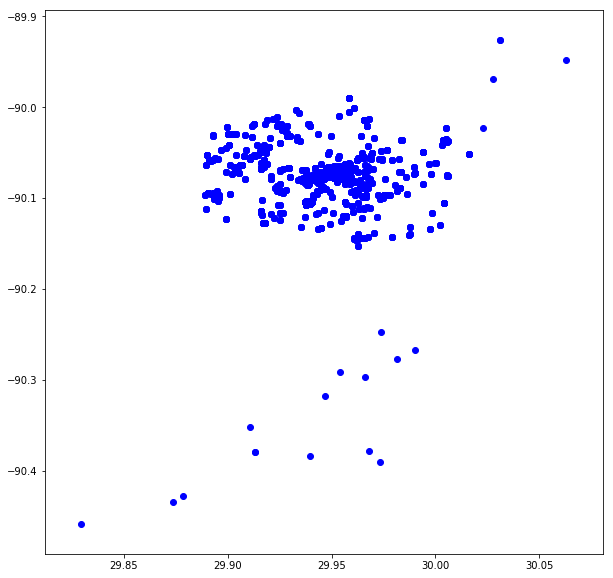

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(data['lat'],data['lng'],c='blue')
plt.show()

In [8]:
center = origin
m = Map(center = center, zoom = 11)

heatmap = Heatmap(
    locations=[(data.loc[i, "lat"], data.loc[i,"lng"]) for i in data.index],
    radius=16
)

m.add_layer(heatmap);

display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …